## Αρχικοποίηση

Σε αυτό το βήμα:

- Εισάγουμε τις βασικές βιβλιοθήκες που θα χρησιμοποιήσουμε.
- Ορίζουμε ρυθμίσεις εμφάνισης για να βλέπουμε πλήρως τις στήλες, τα πλάτη και τα περιεχόμενα των DataFrames

In [1]:
# Φόρτωση απαραίτητων βιβλιοθηκών
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler, RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

## Συνάρτηση `load_data()`

Η συναρτηση αυτή φορτώνει το dataset.

Η συνάρτηση:
- Διαβάζει το αρχείο .csv
- Επιστρέφει ένα DataFrame με τα δεδομένα
- Εμφανίζει τον αριθμό γραμμών και στηλών που φορτώθηκαν

In [2]:
def load_data(filepath):
    """
    Διαβάζει ένα αρχείο CSV και επιστρέφει ένα Dataframe.

    Parameters:
        filepath (str): Η διαδρομή του αρχείου .csv

    Returns:
        df (DataFrame): Τα δεδομένα ως pandas DataFrame
    """
    df = pd.read_csv(filepath)
    print("\n->Dataset φορτώθηκε:", df.shape)
    return df

##  Συνάρτηση `inspect_data(df)`

Η συνάρτηση αυτή μας δίνει μια πρώτη επισκόπηση του dataset:

- Προβάλλει τους τύπους δεδομένων και αν υπάρχουν κενές τιμές
- Δείχνει τις πρώτες 5 γραμμές
- Εμφανίζει βασικά περιγραφικά στατιστικά (mean, std, κ.λπ.)
- Ελέγχει για NaN τιμές ανά στήλη

In [3]:
def inspect_data(df):
    """
    Εμφανίζει βασικές πληροφορίες για το dataset:
    - Τύποι δεδομένων & Nans
    - Πρώτες γραμμές
    - Περιγραφικά στατιστικά
    """
    print("\nΠληροφορίες DataFrame:")
    df.info()
    print("\nΠρώτες 5 γραμμές:")
    print(df.head())
    print("\nΠεριγραφικά στατιστικά:")
    print(df.describe())
    print("\nΈλεγχος για Nan:")
    print(df.isna().sum())

## Συνάρτηση `plot_single_boxplot(column_data, column_name)`

Η συνάρτηση δημιουργεί ένα boxplot για μία αριθμητική στήλη, υπολογίζει τα βασικά στατιστικά και τα όρια outliers με βάση το IQR.

- **Είσοδοι**:
  - `column_data`: η αριθμητική στήλη (σειρά από pandas DataFrame)
  - `column_name`: το όνομα της στήλης για χρήση στον τίτλο του διαγράμματος

- **Τι κάνει**:
  - Υπολογίζει Q1, Q3, IQR
  - Εμφανίζει το boxplot με τίτλο
  - Εκτυπώνει τα στατιστικά και τα όρια για outliers

Χρησιμοποιείται για την ανίχνευση ακραίων τιμών (outliers) σε μεμονωμένες στήλες.

In [4]:
def plot_single_boxplot(column_data, column_name):
    """
    Εμφανίζει οριζόντιο boxplot για μία στήλη και υπολογίζει IQR-based όρια.

    Parameters:
    column_data (Series): Η στήλη που θέλουμε να απεικονίζουμε (π.χ. df["Age"])
    column_name (str): Το όνομα που θα εμφανίζεται στο τίτλο
    """
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-(1.5*IQR)
    upper_bound = Q3+(1.5*IQR)
    
    fig = plt.figure(figsize=(8, 2))
    sns.boxplot(x=column_data)
    plt.title(f"Boxplot - {column_name}")
    plt.xlabel(column_name)
    plt.grid(True)
    #plt.show

    display(fig)
    plt.close(fig)  # για να μην το ξανατυπώσει παρακάτω

    print(f"\nΣτατιστικά για {column_name}")
    print(f"\nQ1 (25%): {Q1:.2f}")
    print(f"\nQ3 (75%): {Q3:.2f}")
    print(f"\nIQR: {IQR:.2f}")
    print(f"\nΠιθανοί outliers κάτω από: {lower_bound:.2f}")
    print(f"\nΠιθανοί outliers πάνω από: {upper_bound:.2f}")

## Συνάρτηση `get_numeric_features(df, exclude=None)`

Η συνάρτηση αυτή επιστρέφει τις αριθμητικές στήλες (int, float) από ένα DataFrame.

- **Είσοδοι**:
  - `df`: το pandas DataFrame που περιέχει τα δεδομένα
  - `exclude` *(προαιρετικό)*: όνομα στήλης που θέλουμε να εξαιρέσουμε (π.χ. "CustomerID")

- **Τι κάνει**:
  - Φιλτράρει τις στήλες τύπου αριθμητικού δεδομένου
  - Αν έχει δοθεί η παράμετρος `exclude` και υπάρχει στο DataFrame, την αφαιρεί από το αποτέλεσμα

Χρησιμοποιείται για την εύκολη απομόνωση μόνο των αριθμητικών χαρακτηριστικών του dataset.

In [5]:
def get_numeric_features(df, exclude=None):
    """
    Επιστρέφει τις αριθμητικές στήλες του DataFrame.

    Parameters:
    df (DataFrame): Τα δεδομένα που περιέχουν τις στήλες
    exclude (str): (Προεραιτικό) Όνομα στήλης προς αφαίρεση από τα αριθμητικά

    Returns:
    Index: Οι αριθμητικές στήλες χωρίς τη στήλη exclude (αν δόθηκε)
    """
    #Βρίσκουμε τις στήλες που είναι αριθμητικού τύπου (int, float...)
    numeric_columns = df.select_dtypes(include=["number"]).columns

    #Αν ζητήθηκε κάποια στήλη για εξαίρεση και υπάρχει μέσα, την αφαιρούμε
    if exclude in numeric_columns:
        numeric_columns = numeric_columns.drop(exclude)

    #Επιστροφή στηλών
    return numeric_columns

## Συνάρτηση `plot_all_numeric_boxplots(df, exclude=None)`

Η συνάρτηση δημιουργεί διαδοχικά boxplots για όλες τις αριθμητικές στήλες του DataFrame, εκτός από τη στήλη που δίνεται στην `exclude`.

- **Είσοδοι**:
  - `df`: το pandas DataFrame με τα δεδομένα
  - `exclude` *(προαιρετικό)*: στήλη που θέλουμε να εξαιρέσουμε (π.χ. "CustomerID")

- **Τι κάνει**:
  - Εντοπίζει τις αριθμητικές στήλες (χρησιμοποιώντας τη συνάρτηση `get_numeric_features`)
  - Καλεί για κάθε μία από αυτές τη συνάρτηση `plot_single_boxplot` ώστε να γίνει γραφική απεικόνιση και έλεγχος outliers

Χρήσιμο για γρήγορο έλεγχο outliers σε όλα τα ποσοτικά δεδομένα του dataset.

In [6]:
def plot_all_numeric_boxplots(df, exclude=None):
    """
    Δημιουργεί boxplots για κάθε αριθμητική στήλη του DataFrame,
    εκτός από τη στήλη που καθορίζεται στην exclude (π.χ. 'CustomerID').
    
    Parameters:
    df (DataFrame): Τα δεδομένα
    exclude (str): (Προαιρετικά) Όνομα στήλης προς αφαίρεση
    """
    #Απομόνωση των αριθμητικών στηλών και αφαίρεση customer id
    numeric_columns = get_numeric_features(df, exclude)

    #Εμφανίζει ένα boxplot και quantiles για κάθε στήλη
    for col in numeric_columns:
        plot_single_boxplot(df[col], col)

## Συνάρτηση `find_outliers_iqr(df, column)`

Η συνάρτηση εντοπίζει τις γραμμές του DataFrame που περιέχουν outliers στη στήλη `column` με βάση το IQR (Interquartile Range).

- **Είσοδοι**:
  - `df`: το pandas DataFrame με τα δεδομένα
  - `column`: το όνομα της στήλης στην οποία ελέγχονται οι τιμές

- **Τι κάνει**:
  - Υπολογίζει τα Q1 (25%) και Q3 (75%) της στήλης
  - Υπολογίζει το IQR = Q3 - Q1
  - Εντοπίζει και επιστρέφει τις γραμμές με τιμές μικρότερες από Q1 - 1.5*IQR ή μεγαλύτερες από Q3 + 1.5*IQR

Δεν αφαιρεί τις γραμμές από το DataFrame — απλώς επιστρέφει τα outliers ως ξεχωριστό DataFrame για μελέτη ή οπτικοποίηση.

In [7]:
def find_outliers_iqr(df, column):
    """
    Επιστρέφει τις γραμμές του DataFrame που είναι outliers
    στη συγκεκριμένη στήλη βάσει του κανόνα 1.5 * IQR.
    
    Parameters:
    df (DataFrame): Τα δεδομένα
    column (str): Το όνομα της στήλης για έλεγχο
    
    Returns:
    DataFrame: Οι γραμμές που είναι outliers
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-(1.5*IQR)
    upper_bound = Q3+(1.5*IQR)

    #Φιλτράρισμα outliers
    outliers = df[(df[column]<lower_bound) | (df[column]>upper_bound)]

    return outliers

## Συνάρτηση `print_outliers_for_all_numeric(df, exclude=None)`

Η συνάρτηση αυτή εμφανίζει τον αριθμό των outliers για κάθε αριθμητική στήλη του DataFrame, χρησιμοποιώντας το κριτήριο του IQR.

- **Είσοδοι**:
  - `df`: pandas DataFrame με τα δεδομένα
  - `exclude` *(προαιρετικό)*: στήλη που θέλουμε να αγνοήσουμε (π.χ. "CustomerID")

- **Τι κάνει**:
  - Εντοπίζει όλες τις αριθμητικές στήλες (εκτός από την `exclude`)
  - Για κάθε στήλη:
    - Εντοπίζει τις outlier τιμές βάσει IQR (μέσω `find_outliers_iqr`)
    - Εμφανίζει πόσα outliers υπάρχουν και τις τιμές τους

Χρησιμοποιείται για συνολική επισκόπηση ακραίων τιμών στο dataset.

In [8]:
def print_outliers_for_all_numeric(df, exclude=None):
    """
    Ελέγχει για outliers σε όλες τις αριθμητικές στήλες (εκτός αυτών που εξαιρούνται)
    και εμφανίζει τα outlier rows για κάθε στήλη ξεχωριστά.
    
    Parameters:
    df (DataFrame): Το DataFrame με τα δεδομένα
    exclude (str): (προαιρετικά) Στήλη προς εξαίρεση, π.χ. 'CustomerID'
    """
    #Βρίσκουμε τις στήλες που είναι αριθμητικού τύπου (int, float...)
    numeric_columns = df.select_dtypes(include=["number"]).columns

    #Αν ζητήθηκε κάποια στήλη για εξαίρεση και υπάρχει μέσα, την αφαιρούμε
    if exclude in numeric_columns:
        numeric_columns = numeric_columns.drop(exclude)

    for col in numeric_columns:
        print(f"\nΈλεγχος outliers στην στήλη:{col}")
        outliers = find_outliers_iqr(df, col)
        if outliers.empty:
            print("\nΔεν βρέθηκαν outliers")
        else:
            print(f"\nΒρέθηκαν {len(outliers)} outliers:")
            print(outliers)

## Συνάρτηση `remove_outliers_iqr(df, columns)`

Η συνάρτηση αφαιρεί από το DataFrame όλες τις γραμμές που περιέχουν outliers σε μία ή περισσότερες από τις καθορισμένες στήλες, χρησιμοποιώντας το κριτήριο του IQR (Interquartile Range).

- **Είσοδοι**:
  - `df`: το αρχικό DataFrame
  - `columns`: λίστα από ονόματα στηλών στις οποίες θέλουμε να αφαιρέσουμε outliers

- **Τι κάνει**:
  - Υπολογίζει για κάθε στήλη το IQR και τα όρια outliers
  - Επαναφέρει νέο DataFrame μόνο με τις γραμμές που **δεν** περιέχουν outliers σε καμία από τις δοθείσες στήλες

Αυτό βοηθά στον καθαρισμό του dataset πριν την εφαρμογή αλγορίθμων clustering.

In [9]:
def remove_outliers_iqr(df, columns):
    """
    Αφαιρεί όλες τις γραμμές που είναι outliers σε οποιαδήποτε από τις δοσμένες στήλες,
    βάσει του IQR κανόνα.
    
    Parameters:
    df (DataFrame): Τα αρχικά δεδομένα
    columns (list): Λίστα με ονόματα στηλών για έλεγχο
    
    Returns:
    DataFrame: Νέο DataFrame χωρίς outliers
    """
    #Χρησιμοποιω set για να αποφύγω διπλότυπα index
    outlier_index = set()
    
    for col in columns:
        outliers = find_outliers_iqr(df, col)
        outlier_index.update(outliers.index)
    
    #Αφαίρεση γραμμών με τα outlier index
    df_cleaned = df.drop(index=outlier_index)

    print(f"Αφαιρέθηκαν {len(df) - len(df_cleaned)} γραμμές με outliers.")

    return df_cleaned

## Συνάρτηση `get_numeric_dataframe(df, exclude=None)`

Η συνάρτηση επιστρέφει ένα νέο DataFrame που περιέχει μόνο τις αριθμητικές στήλες του αρχικού `df`, με δυνατότητα προαιρετικής αφαίρεσης μιας συγκεκριμένης στήλης.

- **Είσοδοι**:
  - `df`: pandas DataFrame με τα δεδομένα
  - `exclude` *(προαιρετικό)*: το όνομα μιας στήλης που θέλουμε να αφαιρέσουμε από το αποτέλεσμα (π.χ. "CustomerID")

- **Τι κάνει**:
  - Εντοπίζει τις στήλες αριθμητικού τύπου (int, float)
  - Αν η `exclude` υπάρχει στο DataFrame, την αφαιρεί
  - Επιστρέφει νέο DataFrame μόνο με τις αριθμητικές στήλες

> **Σημείωση**: Είχε προηγηθεί η συνάρτηση `get_numeric_features(df, exclude=None)`, η οποία όμως επιστρέφει μόνο τα ονόματα των στηλών και όχι ολόκληρο DataFrame.  
> Επειδή η `get_numeric_features` χρησιμοποιείται ήδη από άλλες συναρτήσεις, αποφασίστηκε να **μην τροποποιηθεί**, αλλά να δημιουργηθεί **ξεχωριστή συνάρτηση**, η `get_numeric_dataframe`, που εκτελεί την ίδια λογική αλλά επιστρέφει DataFrame αντί για Index.

In [10]:
def get_numeric_dataframe(df, exclude=None):
    """
    Επιστρέφει νέο DataFrame που περιέχει μόνο αριθμητικές στήλες.
    Αν δοθεί μία στήλη για εξαίρεση, την αφαιρεί από το αποτέλεσμα.

    Parameters:
        df (pd.DataFrame): Το αρχικό DataFrame.
        excluve (str): Το όνομα μιας στήλης που θέλουμε να εξαιρέσουμε.

    Returns:
        pd.DataFrame: Νέο DataFrame με αριθμητικές στήλες, χωρίς τη στήλη προς εξαίρεση (αν υπάρχει).
    """
    #Βρίσκουμε τις στήλες που είναι αριθμητικού τύπου (int, float...)
    numeric_columns = df.select_dtypes(include=["number"]).columns

    #Αν ζητήθηκε κάποια στήλη για εξαίρεση και υπάρχει μέσα, την αφαιρούμε
    if exclude in numeric_columns:
        numeric_columns = numeric_columns.drop(exclude)
        
    # Επιλέγουμε μόνο τις αριθμητικές στήλες (μετά την αφαίρεση)
    df_new = df[numeric_columns]
    
    #Επιστροφή του νέου DataFrame
    return df_new

## Συνάρτηση `analyze_correlations(df, target, method="pearson")`

Η συνάρτηση υπολογίζει τον πίνακα συσχετίσεων όλων των αριθμητικών μεταβλητών ενός DataFrame ως προς μια μεταβλητή-στόχο, και εμφανίζει τα αποτελέσματα σε μορφή heatmap για καλύτερη οπτικοποίηση.

- **Είσοδοι**:
  - `df` *(pd.DataFrame)*: Το DataFrame που περιέχει τις αριθμητικές στήλες.
  - `target` *(str)*: Το όνομα της μεταβλητής-στόχου για την οποία εξετάζεται η συσχέτιση.
  - `method` *(str, προεπιλογή = "pearson")*: Η μέθοδος υπολογισμού συσχέτισης. Επιτρεπτές τιμές: `"pearson"`, `"spearman"`, `"kendall"`.

- **Τι κάνει**:
  - Υπολογίζει τον πίνακα συσχετίσεων όλων των αριθμητικών μεταβλητών
  - Εκτυπώνει μόνο τις συσχετίσεις που αφορούν τη μεταβλητή `target`
  - Εμφανίζει heatmap με τις τιμές των συσχετίσεων
  - Επιστρέφει ολόκληρο τον πίνακα συσχετίσεων για πιθανή περαιτέρω χρήση

Η συνάρτηση είναι χρήσιμη για την αναγνώριση σχετικών χαρακτηριστικών πριν από clustering ή άλλη ανάλυση.

In [11]:
def analyze_correlations(df, target, method="pearson"):
    """
    Υπολογίζει και εμφανίζει τον πίνακα Pearson συσχετίσεων για όλες τις αριθμητικές στήλες,
    και εμφανίζει heatmap για καλύτερη οπτικοποίηση.

    Parameters:
        - **df** (`pd.DataFrame`):  
    Το DataFrame που περιέχει αριθμητικές στήλες στις οποίες θα υπολογιστούν οι συσχετίσεις.

    - **target** (`str`):  
      Το όνομα της στήλης-στόχου για την οποία θα εμφανιστούν οι συσχετίσεις ως προς τις υπόλοιπες.

    - **method** (`str`, προεπιλογή = `"pearson"`):  
      Η μέθοδος που θα χρησιμοποιηθεί για τον υπολογισμό της συσχέτισης.  

    Returns:
        pd.DataFrame: Ο πίνακας συσχετίσεων.
    """
    #Υπολογισμός πίνακα Pearson συσχετίσεων
    correlation_matrix = df.corr(method=method)

    # Επιλογή μόνο της γραμμής που αντιστοιχεί στο target (ως Series)
    target_corr = correlation_matrix[target].drop(labels=[target])

    #Εκτύπωση του πίνακα 
    print(f"\nΠίνακας συσχετίσεων: ({method})")
    print(target_corr)

    #Δημιουργεία heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(target_corr.to_frame().T, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Heatmap Συσχετίσεων")
    plt.show()

    #Επιστροφή του πίνακα για περαιτέρω χρήση
    return correlation_matrix

## Συνάρτηση `scale_features(df, method="standard")`

Η συνάρτηση εφαρμόζει κανονικοποίηση ή τυποποίηση στα αριθμητικά δεδομένα του DataFrame, επιτρέποντας επιλογή από διαφορετικούς scalers της `sklearn.preprocessing`.

- **Υποστηριζόμενα Scalers**:
  - `"standard"` → StandardScaler (τυποποίηση: μέση τιμή 0, std = 1)
  - `"minmax"` → MinMaxScaler (κλίμακα [0, 1])
  - `"maxabs"` → MaxAbsScaler (κλίμακα [-1, 1])
  - `"robust"` → RobustScaler (ανθεκτικός σε outliers, βασισμένος σε median/IQR)
  - `"normalizer"` → Normalizer (κανονικοποίηση γραμμών σε μοναδιαίο διάνυσμα)

- Αν δοθεί μη αποδεκτή τιμή, εφαρμόζεται αυτόματα `standard` και εμφανίζεται προειδοποίηση.

In [12]:
def scale_features(df, method="standard"):
    """
    Κανονικοποιεί/Τυποποιεί τα δεδομένα χρησιμοποιώντας είτε StandardScaler είτε MinMaxScaler.

    Parameters:
        df (pd.DataFrame): DataFrame που περιέχει μόνο αριθμητικές στήλες.
        method (str): Επιλογή scaler:
            - `"standard"`: Τυποποίηση (μέση τιμή 0, std = 1)  
            - `"minmax"`: Κανονικοποίηση στο διάστημα [0, 1]  
            - `"maxabs"`: Κλιμάκωση με βάση τη μέγιστη απόλυτη τιμή ([-1, 1])  
            - `"robust"`: Τυποποίηση ανθεκτική σε outliers (median, IQR)  
            - `"normalizer"`: Κανονικοποίηση κάθε δείγματος ως μοναδιαίο διάνυσμα

    Returns:
        scaled_df: Κανονικοποιημένο DataFrame με ίδιες στήλες και index.
    """
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    elif method == "maxabs":
        scaler = MaxAbsScaler()
    elif method == "robust":
        scaler = RobustScaler()
    elif method == "normalizer":
        scaler = Normalizer()
    else:
        scaler = StandardScaler()
        print("Μη έγκυρη επιλογή method. Επιτρεπτές τιμές: 'standard','minmax','maxabs','robust','normalizer'. Επιλέχθηκε η default -> 'standard'")

    scaled_np = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_np, columns=df.columns, index=df.index)

    return scaled_df

## Συνάρτηση `evaluate_kmeans_range(X, k_range=range(2,11), init_method="k-means++", n_init=10, max_iter=300, tol=1e-4, random_state=42)`

Η συνάρτηση εφαρμόζει τον αλγόριθμο KMeans για ένα εύρος τιμών `k` (αριθμός clusters), αξιολογεί τα αποτελέσματα με τις μεθόδους **Elbow** και **Silhouette**, και εμφανίζει τα αντίστοιχα διαγράμματα.

- **Είσοδοι**:
  - `X`: τα αριθμητικά δεδομένα για clustering (NumPy array ή pandas DataFrame)
  - `k_range`: εύρος τιμών του k που θα δοκιμαστούν (default: `range(2, 11)`)
  - `init_method`: τρόπος αρχικοποίησης των κέντρων (`"k-means++"`, `"random"` ή array-like)
  - `n_init`: πόσες φορές θα γίνει επανεκκίνηση με διαφορετικά αρχικά κέντρα (default: 10)
  - `max_iter`: μέγιστος αριθμός επαναλήψεων για κάθε εκτέλεση (default: 300)
  - `tol`: όριο ανοχής για τερματισμό της σύγκλισης (default: 1e-4)
  - `random_state`: σταθερός σπόρος για επαναληψιμότητα (default: 42)

- **Τι κάνει**:
  - Εκτελεί KMeans για κάθε `k` στο `k_range`
  - Υπολογίζει και αποθηκεύει το `inertia` για το Elbow Plot
  - Υπολογίζει το `silhouette score` για κάθε `k ≥ 2`
  - Εμφανίζει δύο διαγράμματα: Elbow και Silhouette καθώς και το μέγιστο k και Silhouette score

- **Τι επιστρέφει**:
  - Δεν επιστρέφει τιμή.  
    Η συνάρτηση απλώς εμφανίζει γραφήματα αξιολόγησης για την επιλογή του κατάλληλου `k`.

In [13]:
def evaluate_kmeans_range(X, k_range=range(2,11), init_method="k-means++", n_init=10, max_iter=300, tol=1e-4, random_state=42):
    """
    Εκτελεί KMeans για διαφορετικά k και εμφανίζει Elbow & Silhouette Score γραφήματα.
    
    Parameters:
        X (array-like): Τα αριθμητικά δεδομένα για clustering (NumPy array ή DataFrame).
        k_range (range): Εύρος τιμών k προς αξιολόγηση. (default: 2-11).
        init_method (str): Τρόπος αρχικοποίησης ('k-means++', 'random' ή array-like) (default: 'k-means++').
        n_init (int): Πλήθος επαναλήψεων με διαφορετικά αρχικά κέντρα (default: 10).
        max_iter (int): Μέγιστος αριθμός επαναλήψεων για κάθε εκτέλεση (default: 300).
        tol (float): Κατώφλι για τον τερματισμό σύγκλισης (default: 1e-4).
        random_state (int): Τυχαίος σπόρος για επαναληψιμότητα (default: 42).
    
    Returns:
        None
    """
    # Λίστες για το Elbow plot
    elbow_k = []
    elbow_inertia = []
    
    # Λίστες για το Silhouette plot
    silhouette_k = []
    silhouette_scores = []

    for k in k_range:
        if k < 1:
            print(f"\nΤο k πρέπει να είναι ≥ 1. Παραλείπεται: k={k}")
            continue
    
        model = KMeans(
            n_clusters=k,
            init=init_method,
            n_init=n_init,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state
        )
    
        labels = model.fit_predict(X)
    
        # Καταγραφή για Elbow plot
        elbow_k.append(k)
        elbow_inertia.append(model.inertia_)
    
        # Καταγραφή για Silhouette μόνο αν k >= 2
        if k == 1:
            print("\nΤο Silhouette Score δεν ορίζεται για k=1.")
        else:
            score = silhouette_score(X, labels)
            silhouette_k.append(k)
            silhouette_scores.append(score)

    best_score = max(silhouette_scores)
    best_k = silhouette_k[silhouette_scores.index(best_score)]
    print(f"\nΒέλτιστο Silhouette Score: {best_score:.4f} για k = {best_k}")
    
    # Elbow plot
    plt.figure(figsize=(8, 6))
    plt.plot(elbow_k, elbow_inertia, marker='o', linestyle='--', color='b')
    plt.title("Elbow Method for Optimal K")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.xticks(elbow_k)
    plt.grid()
    plt.show()
    
    # Silhouette plot
    plt.figure(figsize=(8, 6))
    plt.plot(silhouette_k, silhouette_scores, marker='o', linestyle='--', color='g')
    plt.title("Silhouette Method for Optimal K")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.xticks(silhouette_k)
    plt.grid()
    plt.show()

## Συνάρτηση `run_kmeans(X, n_clusters=8, init_method='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=42)`

Η συνάρτηση εκπαιδεύει το μοντέλο KMeans με βάση τα δεδομένα `X` και τις παραμέτρους που δίνονται, και εμφανίζει βασικά αποτελέσματα του clustering (κέντρα, ετικέτες, inertia).

- **Είσοδοι**:
  - `X`: τα αριθμητικά δεδομένα για clustering (NumPy array ή pandas DataFrame)
  - `n_clusters`: αριθμός των clusters που θα δημιουργηθούν (default: 8)
  - `init_method`: τρόπος αρχικοποίησης των κέντρων (`'k-means++'`, `'random'`, ή array-like)
  - `n_init`: αριθμός επανεκκινήσεων με διαφορετικά αρχικά κέντρα (default: 10)
  - `max_iter`: μέγιστος αριθμός επαναλήψεων για κάθε εκτέλεση (default: 300)
  - `tol`: κατώφλι για την ολοκλήρωση της σύγκλισης (default: 1e-4)
  - `random_state`: σταθερός σπόρος για επαναληψιμότητα (default: 42)

- **Τι κάνει**:
  - Εκπαιδεύει KMeans με βάση τα δεδομένα και τις παραμέτρους
  - Εμφανίζει:
    - την τιμή του inertia

- **Τι επιστρέφει**:
  - Το εκπαιδευμένο αντικείμενο `kmeans`, το οποίο μπορεί να χρησιμοποιηθεί για περαιτέρω προβλέψεις ή ανάλυση

In [14]:
def run_kmeans(X, n_clusters=8, init_method='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=42):
    """
    Εκπαιδεύει το μοντέλο KMeans με τα δεδομένα και επιστρέφει το μοντέλο και τις ετικέτες.

    Parameters:
        X (array-like): Τα αριθμητικά δεδομένα για clustering (NumPy array ή DataFrame).
        n_clusters (int): Αριθμός των clusters.
        init_method (str): Τρόπος αρχικοποίησης ('k-means++', 'random' ή array-like) (default: 'k-means++').
        n_init (int): Πλήθος επαναλήψεων με διαφορετικά αρχικά κέντρα (default: 10).
        max_iter (int): Μέγιστος αριθμός επαναλήψεων για κάθε εκτέλεση (default: 300).
        tol (float): Κατώφλι για τον τερματισμό σύγκλισης (default: 1e-4)..
        random_state (int): Τυχαίος σπόρος για επαναληψιμότητα (default: 42).

    Returns:
        kmeans (KMeans): Το εκπαιδευμένο μοντέλο.
    """
    kmeans=KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init,
        max_iter=max_iter,
        tol=tol,
        random_state=random_state
    )

    kmeans.fit(X)
    #print("Cluster Centers:\n", kmeans.cluster_centers_)
    #print("Labels:\n", kmeans.labels_)
    print("Inertia:\n", kmeans.inertia_)
    return kmeans

## Συνάρτηση `visualize_clusters(model, df, features, mode="2D")`

Η συνάρτηση οπτικοποιεί τα αποτελέσματα του KMeans clustering είτε σε 2D είτε σε 3D scatter plot, χρησιμοποιώντας τις στήλες που ορίζονται στη λίστα `features`.

- **Είσοδοι**:
  - `model`: το εκπαιδευμένο μοντέλο KMeans που περιέχει τα labels και τα centroids
  - `df`: το pandas DataFrame με τα αρχικά δεδομένα και τις ονομασίες των στηλών
  - `features`: λίστα με 2 ή 3 ονόματα στηλών που θα χρησιμοποιηθούν για την οπτικοποίηση
  - `mode`: `"2D"` ή `"3D"` για επιλογή του τύπου διαγράμματος (default: `"2D"`)

- **Τι κάνει**:
  - Ελέγχει ότι οι ζητούμενες στήλες υπάρχουν στο DataFrame
  - Προβάλλει scatter plot των clusters βάσει των τιμών των `features`
  - Εμφανίζει τα κέντρα των clusters
  - Χρησιμοποιεί 3D προβολή αν ζητηθεί και έχουν δοθεί 3 στήλες

- **Τι επιστρέφει**:
  - Δεν επιστρέφει τιμή — η έξοδος είναι μόνο γραφική απεικόνιση (2D ή 3D scatter plot)

In [15]:
def visualize_clusters(model, df,features, mode="2D"):
    """
    Οπτικοποιεί τα clusters που έχουν παραχθεί από KMeans σε 2D ή 3D scatter plot.

    Parameters:
        model (KMeans): Εκπαιδευμένο μοντέλο KMeans.
        df (pd.DataFrame): Τα δεδομένα (με ονόματα στηλών).
        features (list): Λίστα με 2 ή 3 ονόματα στηλών για οπτικοποίηση.
        mode (str): '2D' ή '3D'

    Returns:
        None
    """
    # Έλεγχος εγκυρότητας τιμής για το mode (2D ή 3D)
    if mode not in ["2D","3D"]:
        print("\nΕπιτρεπτές τιμές για mode: '2D' ή '3D'")
        return

    # Έλεγχος ότι όλες οι στήλες υπάρχουν στο DataFrame
    for col in features:
        if col not in df.columns:
            print(f"\nΗ στήλη '{col}' δεν υπαρχει στο DataFrame.")
            return

    # Απόσπαση ετικετών cluster από το εκπαιδευμένο μοντέλο
    labels = model.labels_

    # Απόσπαση συντεταγμένων των centroids (σε μορφή NumPy array)
    centroids = model.cluster_centers_

    # === 2D Visualization ===
    if mode == '2D':
        x_col, y_col = features[0], features[1]
        plt.figure(figsize=(8,6))

        # Σχεδίαση παρατηρήσεων με χρώμα ανάλογο του cluster
        plt.scatter(
            df[x_col],
            df[y_col],
            c=labels,
            cmap='viridis',
            s=50
        )
        
        # Σχεδίαση των κέντρων των clusters
        plt.scatter(
            centroids[:, df.columns.get_loc(x_col)],
            centroids[:, df.columns.get_loc(y_col)],
            c='red',
            s=200,
            marker='X',
            label='Centroids'
        )
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title("Cluster Visualization (2D)")
        plt.legend()
        plt.grid(True)
        plt.show()

    # === 3D Visualization ===
    elif mode == '3D':
        if len(features) < 3:
            print("\nΓια προβολή 2D απαιτούνται 3 στήλες.")
            return

        x_col, y_col, z_col = features[0], features[1], features[2]
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df[x_col], df[y_col], df[z_col], c=labels, cmap='Set2', s=50)

        # Σχεδίαση centroids στον 3D χώρο
        ax.scatter(
            centroids[:, df.columns.get_loc(x_col)],
            centroids[:, df.columns.get_loc(y_col)],
            centroids[:, df.columns.get_loc(z_col)],
            c='red',
            s=200,
            marker='X',
            label='Centroids'
        )
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        plt.title("Cluster Visualization (3D)")
        plt.legend()
        plt.show()

## Συνάρτηση: analyze_top_cluster(model, df, target="Spending Score (1-100)", threshold=80, exclude=None)

Η συνάρτηση αναλύει τα αποτελέσματα του μοντέλου KMeans και εντοπίζει **όλα τα clusters** με μέση τιμή μεγαλύτερη ή ίση του `threshold` για μια επιλεγμένη μεταβλητή στόχο (π.χ. *Spending Score (1-100)*).

### Εισόδοι:

- `model` *(KMeans)*: Το εκπαιδευμένο μοντέλο KMeans
- `df` *(DataFrame)*: Το DataFrame πριν από οποιοδήποτε scaling
- `target` *(str, προεπιλογή: "Spending Score (1-100)")*: Η μεταβλητή που θέλουμε να μεγιστοποιήσουμε (βάσει της οποίας αξιολογούμε τα clusters)
- `threshold` *(int ή float, προεπιλογή: 80):* Το ελάχιστο αποδεκτό μέσο του target για να συμπεριληφθεί ένα cluster.
- `exclude` *(str ή λίστα)*: Ονόματα στηλών προς εξαίρεση από την ανάλυση (π.χ. `Gender_code`)

### Τι κάνει:

- Υπολογίζει τον μέσο όρο της μεταβλητής `target` για κάθε cluster.
- Εντοπίζει όλα τα clusters με `mean >= threshold`.
- Εκτυπώνει τη μέση τιμή για τα επιλεγμένα clusters.
- Εμφανίζει περιγραφικά στατιστικά (`describe()`) για κάθε ένα από αυτά τα clusters.


### Τι επιστρέφει:

- **Δεν επιστρέφει τιμή**. Η συνάρτηση εκτυπώνει τα αποτελέσματα στην οθόνη.

In [16]:
def analyze_top_cluster(model, df, target="Spending Score (1-100)", threshold=80, exclude=None):
    """
    Εκτυπώνει περιγραφικά στατιστικά (describe) για όλα τα clusters που έχουν
    μέση τιμή στη στήλη target μεγαλύτερη ή ίση από το threshold.

    Parameters:
        model (KMeans): Το εκπαιδευμένο KMeans μοντέλο
        df (pd.DataFrame): Το DataFrame με τα αρχικά (πριν scaling) δεδομένα
        target (str): Η στήλη βάσει της οποίας θα γίνει η αξιολόγηση (default: "Spending Score (1-100)")
        threshold (int ή float): Το κατώφλι μέσης τιμής target, πάνω από το οποίο ένα cluster θεωρείται ενδιαφέρον.
        exclude (str ή λίστα str): Ονόματα στηλών προς εξαίρεση (π.χ. 'Gender_code')

    Returns:
        None: Η συνάρτηση εκτυπώνει αποτελέσματα και δεν επιστρέφει τιμή.
    """
    df_working = df.copy()
    # Αν υπάρχει exclude, αφαιρείται
    if exclude:
        df_working = df_working.drop(exclude, axis=1, errors='ignore')

    # Προσθήκη cluster labels από το μοντέλο
    df_working["Cluster"] = model.labels_

    # Ομαδοποίηση ανά cluster και υπολογισμός της μέσης τιμής του target
    summary = df_working.groupby("Cluster")[target].agg(["mean"]).sort_values(by="mean", ascending=False)

    # Επιλογή cluster που πληρούν το κατώφλι threshold
    selected_clusters = []
    for index in summary.index:
        mean_value = summary.loc[index, "mean"]
        if mean_value >= threshold:
            selected_clusters.append(index)

   # Αν δεν βρεθούν κατάλληλα clusters, εμφανίζεται μήνυμα και τερματισμός
    if not selected_clusters:
        print(f"Δεν βρέθηκε κανένα cluster με μέση τιμή {target} >= {threshold}")
        return 

    # Εμφάνιση των επιλεγμένων clusters με τις μέσες τιμές τους
    print(f"Clusters με μέση τιμή {target} >= {threshold}:\n")
    print(summary.loc[selected_clusters])

    # Εκτύπωση περιγραφικών στατιστικών για κάθε επιλεγμένο cluster
    for cluster_id in selected_clusters:
        filtered = df_working[df_working["Cluster"] == cluster_id]
        print(f"\nΠεριγραφικά στατιστικά για Cluster {cluster_id}:\n")
        print(filtered.describe())


## Βήμα 1: Φόρτωση Δεδομένων

Σε αυτό το βήμα φορτώνουμε το αρχείο `mall_customers.csv` από τον φάκελο `datasets`, χρησιμοποιώντας τη συνάρτηση `load_data()` που ορίσαμε νωρίτερα.

Η συνάρτηση:
- Διαβάζει το αρχείο .csv
- Επιστρέφει ένα pandas DataFrame
- Εμφανίζει τον αριθμό γραμμών και στηλών του dataset

Σκοπός του βήματος:
Να διασφαλίσουμε ότι το αρχείο φορτώνεται σωστά και το dataset είναι διαθέσιμο για ανάλυση.

In [17]:
df = load_data("datasets/mall_customers.csv")


->Dataset φορτώθηκε: (200, 5)


## Βήμα 2: Επισκόπηση του Dataset

Σε αυτό το στάδιο χρησιμοποιούμε τη συνάρτηση `inspect_data(df)` για να έχουμε μια πρώτη εικόνα των δεδομένων μας:

- Πληροφορίες σχετικά με τους τύπους μεταβλητών (object, int, float)
- Πρώτες 5 εγγραφές για γρήγορη οπτική κατανόηση
- Περιγραφικά στατιστικά για αριθμητικές στήλες (μέση τιμή, τυπική απόκλιση κ.λπ.)
- Έλεγχος για τυχόν ελλιπείς (NaN) τιμές

Σκοπός του βήματος:
Να εντοπίσουμε τυχόν προβλήματα στα δεδομένα (όπως ελλείψεις ή περίεργες τιμές) και να επιβεβαιώσουμε τη δομή του dataset.

In [18]:
inspect_data(df)


Πληροφορίες DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Πρώτες 5 γραμμές:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Περιγραφικά 

## Συμπεράσματα από τον έλεγχο:

    Γραμμές: 200

    Στήλες: 5

    Καμία ελλιπής τιμή (NaN).

    Οι στήλες είναι:

        CustomerID: αναγνωριστικό, δεν θα χρησιμοποιηθεί στο clustering

        Gender: κατηγορική (θα τη μετατρέψουμε αργότερα)

        Age, Annual Income (k$), Spending Score (1-100): αριθμητικές, βασικές για clustering

## Βήμα 3: Οπτικός Εντοπισμός Outliers (Boxplots)

Σε αυτό το βήμα δημιουργούμε boxplots για όλες τις αριθμητικές στήλες του dataset, εκτός από το `CustomerID`.

Σκοπός:
Να εντοπίσουμε ακραίες τιμές (outliers) οπτικά μέσω των γραφικών παραστάσεων, ώστε να αποφασίσουμε αν και πού απαιτείται καθαρισμός.

Η ανάλυση θα συνεχιστεί με αριθμητικό έλεγχο outliers μέσω IQR.

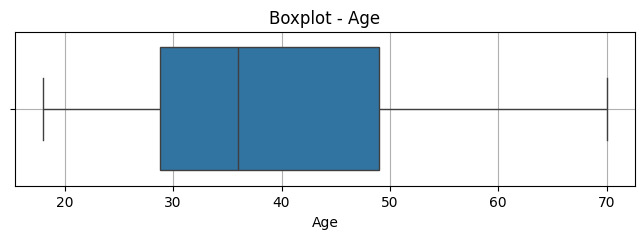


Στατιστικά για Age

Q1 (25%): 28.75

Q3 (75%): 49.00

IQR: 20.25

Πιθανοί outliers κάτω από: -1.62

Πιθανοί outliers πάνω από: 79.38


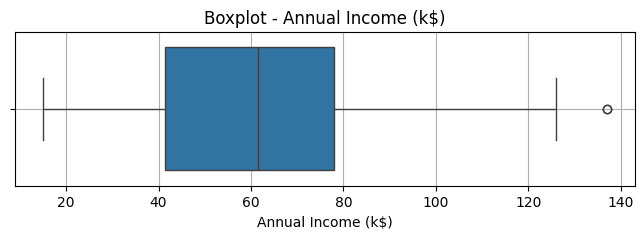


Στατιστικά για Annual Income (k$)

Q1 (25%): 41.50

Q3 (75%): 78.00

IQR: 36.50

Πιθανοί outliers κάτω από: -13.25

Πιθανοί outliers πάνω από: 132.75


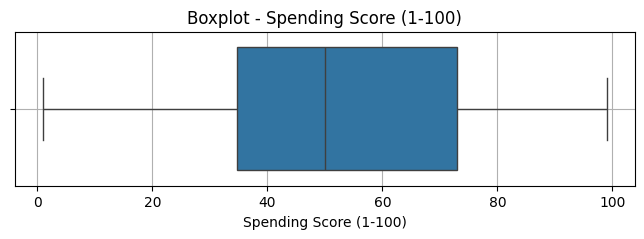


Στατιστικά για Spending Score (1-100)

Q1 (25%): 34.75

Q3 (75%): 73.00

IQR: 38.25

Πιθανοί outliers κάτω από: -22.62

Πιθανοί outliers πάνω από: 130.38


In [19]:
plot_all_numeric_boxplots(df, exclude="CustomerID")

## Βήμα 4: Γρήγορος Εντοπισμός Outliers για Επεξεργασία

Σύμφωνα με την εκφώνηση, πραγματοποιούμε σύντομο καθαρισμό "ακραίων" ή "παράλογων" τιμών, επικεντρώνοντας την προσοχή μας στις μεταβλητές:

- `Annual Income (k$)`
- `Spending Score (1-100)`

Χρησιμοποιούμε τη συνάρτηση `print_outliers_for_all_numeric()` για να εντοπίσουμε outliers και να επιβεβαιώσουμε την ανάγκη καθαρισμού.

Δεν εφαρμόζουμε εξαντλητικό καθαρισμό σε όλο το dataset, μόνο σε επιλεγμένες μεταβλητές και μόνο αν αυτό κρίνεται απαραίτητο.

In [20]:
print_outliers_for_all_numeric(df, exclude="CustomerID")


Έλεγχος outliers στην στήλη:Age

Δεν βρέθηκαν outliers

Έλεγχος outliers στην στήλη:Annual Income (k$)

Βρέθηκαν 2 outliers:
     CustomerID Gender  Age  Annual Income (k$)  Spending Score (1-100)
198         199   Male   32                 137                      18
199         200   Male   30                 137                      83

Έλεγχος outliers στην στήλη:Spending Score (1-100)

Δεν βρέθηκαν outliers


## Βήμα 5: Αφαίρεση Outliers από Annual Income

Αφαιρούμε τις γραμμές που περιέχουν ακραίες τιμές (outliers) στην στήλη `Annual Income (k$)`, χρησιμοποιώντας τη συνάρτηση `remove_outliers_iqr()`.

In [21]:
columns_to_check = ['Annual Income (k$)']
df_cleaned = remove_outliers_iqr(df, columns_to_check)

Αφαιρέθηκαν 2 γραμμές με outliers.


## Βήμα 6: Επαναξιολόγηση Outliers μετά τον Καθαρισμό

Επαναλαμβάνουμε τον έλεγχο outliers στο νέο dataset `df_cleaned`, τόσο οπτικά όσο και αριθμητικά, για να επιβεβαιώσουμε ότι:

- Οι ακραίες τιμές στο `Annual Income (k$)` έχουν αφαιρεθεί επιτυχώς
- Δεν υπάρχουν νέες εμφανίσεις outliers λόγω του καθαρισμού

Boxplots και αριθμητική ανάλυση χρησιμοποιούνται και πάλι, αποκλείοντας το `CustomerID`.

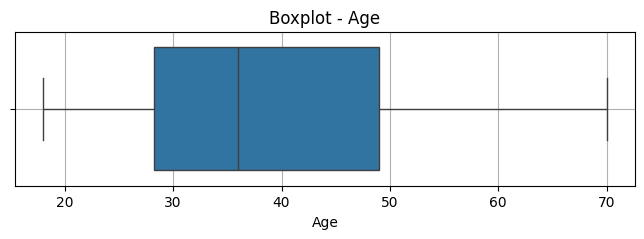


Στατιστικά για Age

Q1 (25%): 28.25

Q3 (75%): 49.00

IQR: 20.75

Πιθανοί outliers κάτω από: -2.88

Πιθανοί outliers πάνω από: 80.12


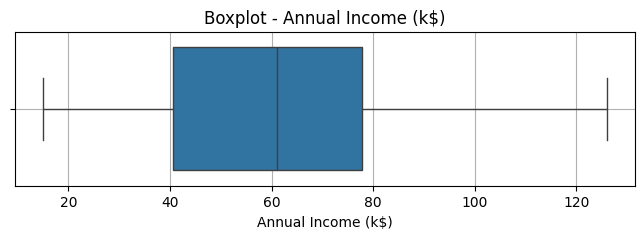


Στατιστικά για Annual Income (k$)

Q1 (25%): 40.50

Q3 (75%): 77.75

IQR: 37.25

Πιθανοί outliers κάτω από: -15.38

Πιθανοί outliers πάνω από: 133.62


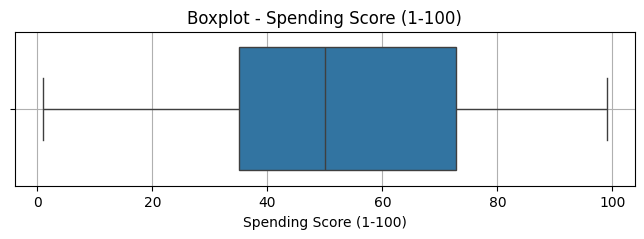


Στατιστικά για Spending Score (1-100)

Q1 (25%): 35.00

Q3 (75%): 72.75

IQR: 37.75

Πιθανοί outliers κάτω από: -21.62

Πιθανοί outliers πάνω από: 129.38


In [22]:
plot_all_numeric_boxplots(df_cleaned, exclude="CustomerID")

In [23]:
print_outliers_for_all_numeric(df_cleaned, exclude="CustomerID")


Έλεγχος outliers στην στήλη:Age

Δεν βρέθηκαν outliers

Έλεγχος outliers στην στήλη:Annual Income (k$)

Δεν βρέθηκαν outliers

Έλεγχος outliers στην στήλη:Spending Score (1-100)

Δεν βρέθηκαν outliers


## Βήμα 7: Ανάλυση Συσχέτισης και Επιλογή Χαρακτηριστικών

Σύμφωνα με την εκφώνηση, εξετάζουμε τις συσχετίσεις των μεταβλητών `Age` και `Gender` ως προς τη μεταβλητή στόχο `Spending Score (1-100)`.

---

### Έλεγχος εγκυρότητας της μεταβλητής `Gender`

Πριν μετατρέψουμε τη μεταβλητή `Gender` σε αριθμητική μορφή για να υπολογίσουμε συσχετίσεις, εκτελούμε δύο ελέγχους:

1. **Έλεγχος μοναδικών τιμών**:
   Επιβεβαιώνουμε ότι η στήλη `Gender` περιέχει μόνο τις αναμενόμενες κατηγορίες (`Male`, `Female`).

2. **Έλεγχος κατανομής τιμών (value counts)**:
   Αν μία τιμή υπερτερεί συντριπτικά (π.χ. 90% `Male`), τότε η μεταβλητή μπορεί να μην προσφέρει ουσιαστική διαφοροποίηση και πιθανόν να αποκλειστεί από τη διαδικασία clustering.

---

### Μετατροπή σε αριθμητική μορφή (μόνο αν πληρούνται οι παραπάνω συνθήκες)

Αν οι τιμές είναι έγκυρες και η κατανομή είναι ικανοποιητικά ισορροπημένη, δημιουργούμε τη νέα στήλη `Gender_code` με τιμές:
- `"Male"` → `0`
- `"Female"` → `1`

Αυτή η μεταβλητή χρησιμοποιείται μόνο για την ανάλυση συσχέτισης.

In [24]:
# Έλεγχος μοναδικών τιμών
print(df_cleaned["Gender"].unique())

['Male' 'Female']


In [25]:
# Έλεγχος ομοιομορφίας κατανομής
print(df_cleaned["Gender"].value_counts())

Gender
Female    112
Male       86
Name: count, dtype: int64


## Τι έδειξε ο έλεγχος:

    Μοναδικές τιμές: 'Male', 'Female' καμία ανεπιθύμητη τιμή

    Κατανομή:

        Female: 112

        Male: 86
        Η κατανομή είναι σχετικά ισορροπημένη (56% - 44%) δεν υπάρχει υπερίσχυση μιας κατηγορίας

Άρα, έχει νόημα να συνεχίσουμε με τη μετατροπή σε αριθμητική μορφή (Gender_code) και να προχωρήσουμε στον υπολογισμό συσχετίσεων.

In [26]:
# Δημιουργία Gender_code για συσχέτιση
df_cleaned["Gender_code"] = df_cleaned["Gender"].map({"Male": 0, "Female": 1})


## Ανάλυση Συσχέτισης με Spending Score

Έχοντας δημιουργήσει αριθμητική μεταβλητή `Gender_code`, προχωρούμε στον υπολογισμό συσχετίσεων μεταξύ των εξής χαρακτηριστικών:

- `Age`
- `Annual Income (k$)`
- `Gender_code`

σε σχέση με τη μεταβλητή στόχο:

- `Spending Score (1-100)`

Η μεταβλητή `CustomerID` αγνοείται, καθώς είναι απλά μοναδικό αναγνωριστικό και δεν περιέχει χρήσιμη πληροφορία.

In [27]:
# Επιλογή μεταβλητών για συσχέτιση
df_corr_input = get_numeric_dataframe(df_cleaned, exclude="CustomerID")
print(df_corr_input.head())

   Age  Annual Income (k$)  Spending Score (1-100)  Gender_code
0   19                  15                      39            0
1   21                  15                      81            0
2   20                  16                       6            1
3   23                  16                      77            1
4   31                  17                      40            1


## Βήμα 8: Ανάλυση Συσχέτισης με Spending Score

Έχοντας εξαγάγει όλες τις αριθμητικές στήλες με τη `get_numeric_dataframe()`, υπολογίζουμε τώρα τη συσχέτιση κάθε χαρακτηριστικού ως προς τη μεταβλητή στόχο `Spending Score (1-100)`.

Χρησιμοποιούμε τη συνάρτηση `analyze_correlations()` με μέθοδο Pearson.

Σκοπός:
Να αξιολογηθεί ποια χαρακτηριστικά έχουν επαρκή πληροφοριακή αξία ώστε να συμπεριληφθούν στο clustering.


Πίνακας συσχετίσεων: (pearson)
Age                  -0.329421
Annual Income (k$)    0.010080
Gender_code           0.059092
Name: Spending Score (1-100), dtype: float64


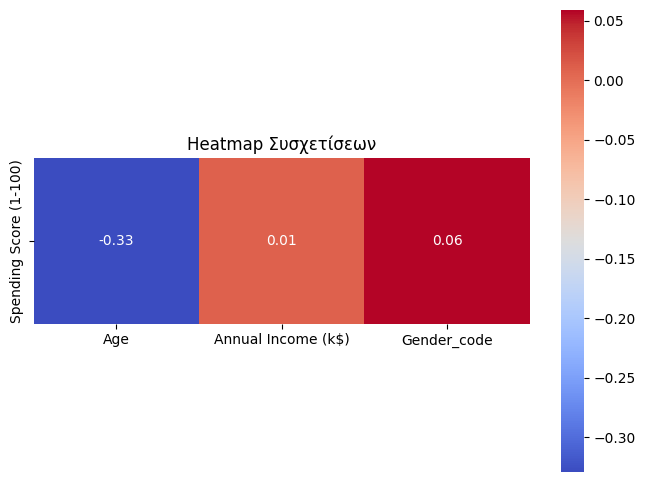

In [28]:
# Υπολογισμός συσχετίσεων
correlations = analyze_correlations(df_corr_input, target="Spending Score (1-100)")

## Συμπεράσματα από την Ανάλυση Συσχέτισης

- `Age`: Μέτρια αρνητική συσχέτιση (−0.33)  ενδέχεται να συμβάλλει στον διαχωρισμό των ομάδων.
- `Annual Income (k$)`: Σχεδόν μηδενική συσχέτιση (+0.01)  πιθανώς δεν προσφέρει διαχωριστική πληροφορία, αλλά θα εξεταστεί σε συνδυασμό με άλλα χαρακτηριστικά.
- `Gender_code`: Πολύ ασθενής θετική συσχέτιση (+0.06)  δεν φαίνεται να προσφέρει ουσιαστική πληροφορία, αλλά θα δοκιμαστεί πειραματικά.

Θα ακολουθήσει πειραματική αξιολόγηση διαφόρων συνδυασμών χαρακτηριστικών για να διαπιστωθεί ποιο σύνολο δημιουργεί πιο χρήσιμα clusters.

## Βήμα 9: Scaling για Συγκρίσιμους Συνδυασμούς

Αρχικά είχα αποφασίσει να μην συμπεριλάβω τη μεταβλητή `Gender_code`, λόγω της πολύ ασθενούς συσχέτισής της με το `Spending Score`. Ωστόσο, στο πλαίσιο πειραματικών δοκιμών, θα εξετάσω και συνδυασμούς χαρακτηριστικών που περιλαμβάνουν τη `Gender_code`.

Αυτό σημαίνει ότι:
- Οι μεταβλητές που θα συμμετέχουν στο clustering μπορεί να έχουν **πολύ διαφορετικές κλίμακες**
- Η `Gender_code` έχει range 0–1, ενώ άλλες όπως `Annual Income (k$)` φτάνουν μέχρι και 137
- Ο αλγόριθμος KMeans, που βασίζεται στην **ευκλείδεια απόσταση**, είναι ευαίσθητος σε τέτοιες ασυμμετρίες

### Έλεγχος Κατανομών

Για να επιλέξουμε κατάλληλη μέθοδο scaling, εξετάστηκαν τα **ιστογράμματα** των αριθμητικών μεταβλητών (`Age`, `Annual Income (k$)`, `Spending Score (1-100)`, `Gender_code`).

Παρατηρήθηκε ότι **οι περισσότερες στήλες δεν ακολουθούν κανονική κατανομή**.

### Επιλογή Scaling

Βάσει αυτής της παρατήρησης, **επιλέγεται η χρήση του `MinMaxScaler`**, επειδή:

- Είναι κατάλληλος **όταν οι μεταβλητές έχουν ανομοιόμορφες κατανομές**
- Κρατά τις τιμές σε σταθερό εύρος [0, 1]
- Δεν απαιτεί κανονικότητα κατανομής
- Δεν επηρεάζει τα μηδενικά (zero-preserving)

Αυτή η στρατηγική τεκμηριώνεται και από το υλικό του μαθήματος, όπου αναφέρεται:
"Use `MinMaxScaler` when the data has varying scales and is not normally distributed, or when preserving zero values is important."

## Έλεγχος κατανομών

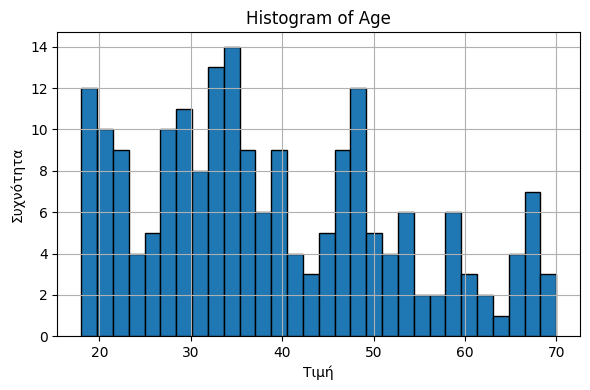

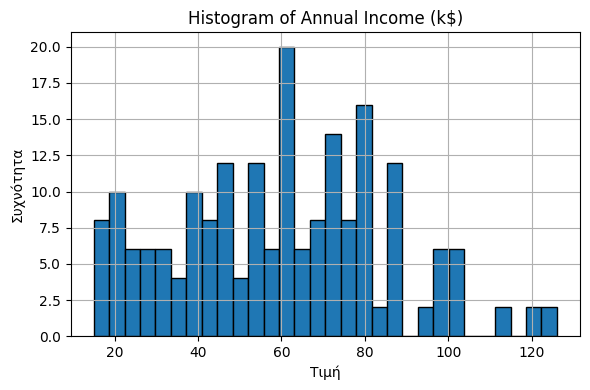

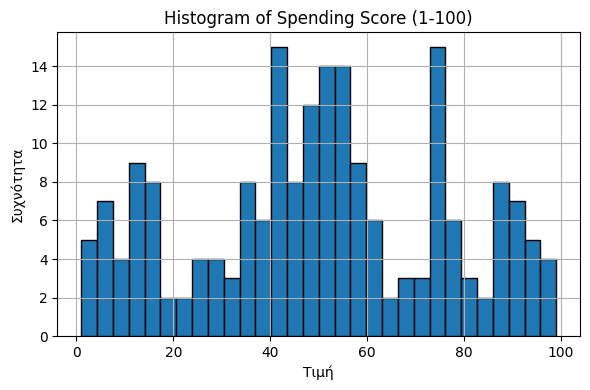

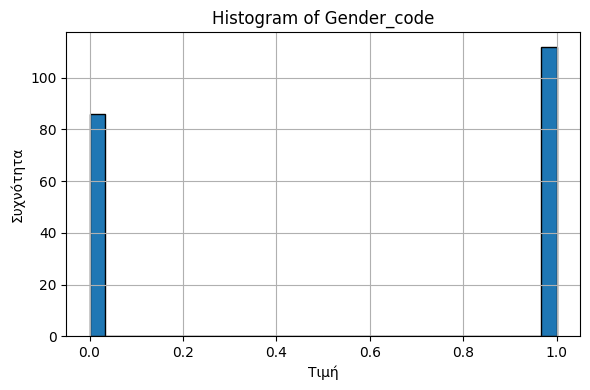

In [29]:
# Βρόχος για κάθε αριθμητική στήλη
for column in df_corr_input.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 4))
    plt.hist(df_corr_input[column].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel('Τιμή')
    plt.ylabel('Συχνότητα')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Εφαρμογή Scaling στα Αριθμητικά Δεδομένα

Χρησιμοποιείται η συνάρτηση `scale_features()` με επιλογή:

```python
scaled_df = scale_features(df_corr_input, method="minmax")

In [30]:
scaled_df = scale_features(df_corr_input, method="minmax")

In [31]:
print(scaled_df)

          Age  Annual Income (k$)  Spending Score (1-100)  Gender_code
0    0.019231            0.000000                0.387755          0.0
1    0.057692            0.000000                0.816327          0.0
2    0.038462            0.009009                0.051020          1.0
3    0.096154            0.009009                0.775510          1.0
4    0.250000            0.018018                0.397959          1.0
..        ...                 ...                     ...          ...
193  0.384615            0.882883                0.918367          1.0
194  0.557692            0.945946                0.153061          1.0
195  0.326923            0.945946                0.795918          1.0
196  0.519231            1.000000                0.275510          1.0
197  0.269231            1.000000                0.744898          0.0

[198 rows x 4 columns]


## Βήμα 10: Πειραματική Αναζήτηση του Βέλτιστου k για Κάθε Συνδυασμό

Σε αυτό το στάδιο ορίζουμε 4 διαφορετικούς συνδυασμούς χαρακτηριστικών για να εξετάσουμε ποιο σύνολο μεταβλητών δημιουργεί τα πιο σαφή και διακριτά clusters. Οι συνδυασμοί είναι:

1. `["Age", "Gender_code", "Annual Income (k$)", "Spending Score (1-100)"]`
2. `["Age", "Annual Income (k$)", "Spending Score (1-100)"]`
3. `["Age", "Gender_code", "Spending Score (1-100)"]`
4. `["Age", "Spending Score (1-100)"]`

Για κάθε ένα από τα παραπάνω σύνολα:
- Εκτελούμε την `evaluate_kmeans_range()` για τιμές `k` από 2 έως 19
- Παρατηρούμε τα γραφήματα Elbow και Silhouette
- Στόχος είναι να εντοπίσουμε ποιο `k` προσφέρει τη βέλτιστη ισορροπία μεταξύ συμπαγών και καλά διαχωρισμένων clusters

Το scaling έχει ήδη εφαρμοστεί προηγουμένως και χρησιμοποιείται το `scaled_df`.

In [32]:
feature_sets = [
    ["Age", "Gender_code", "Annual Income (k$)", "Spending Score (1-100)"],
    ["Age", "Annual Income (k$)", "Spending Score (1-100)"],
    ["Age", "Gender_code", "Spending Score (1-100)"],
    ["Age", "Spending Score (1-100)"]
]


Τρέχουμε αξιολόγηση για: ['Age', 'Gender_code', 'Annual Income (k$)', 'Spending Score (1-100)']

Βέλτιστο Silhouette Score: 0.5135 για k = 2


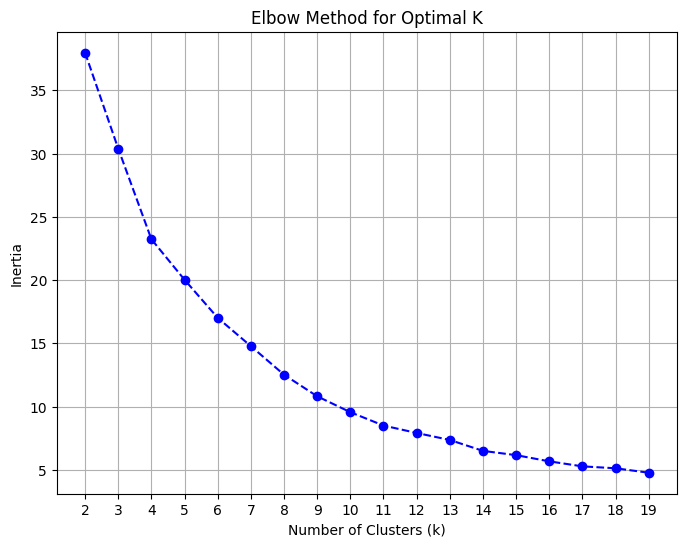

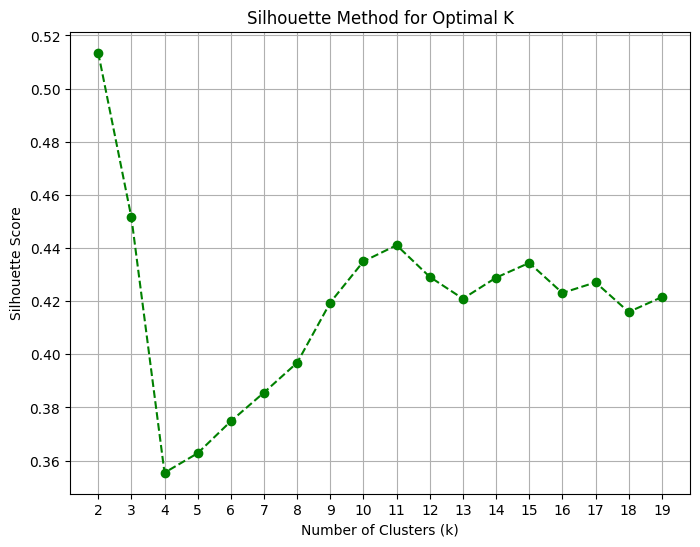


Τρέχουμε αξιολόγηση για: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Βέλτιστο Silhouette Score: 0.4307 για k = 9


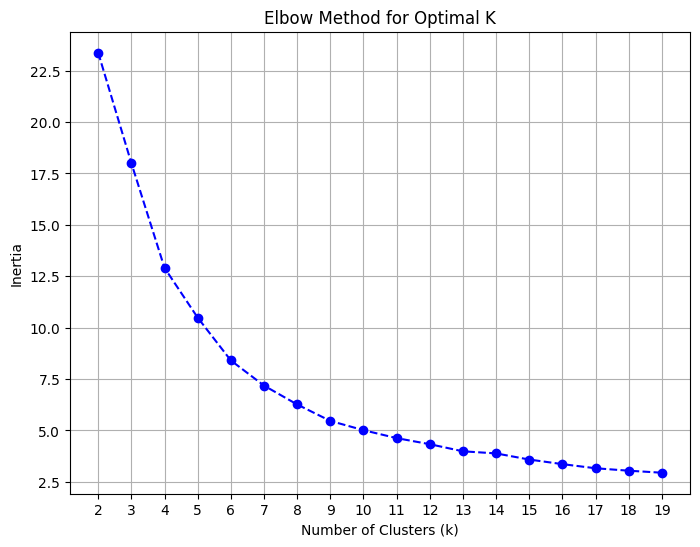

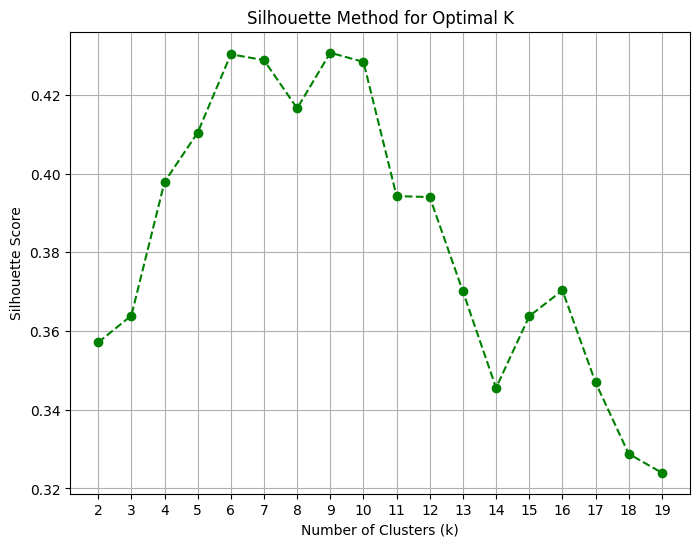


Τρέχουμε αξιολόγηση για: ['Age', 'Gender_code', 'Spending Score (1-100)']

Βέλτιστο Silhouette Score: 0.5824 για k = 2


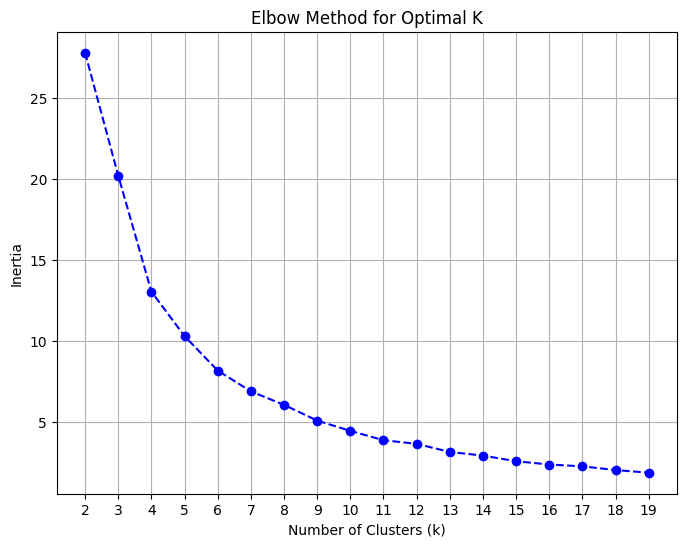

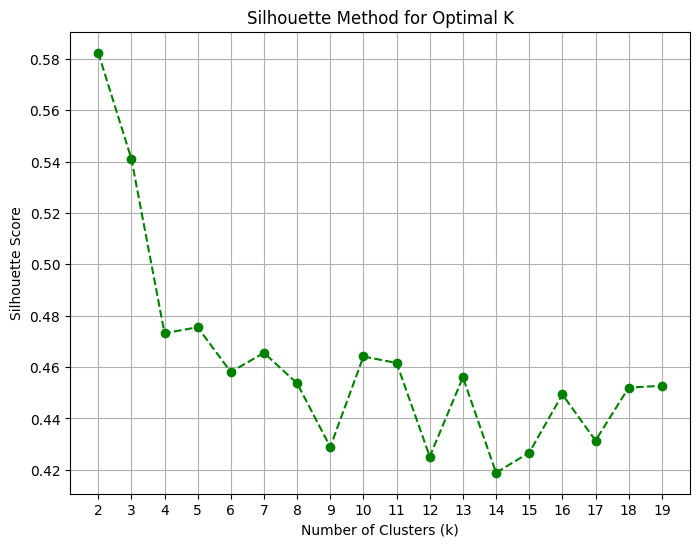


Τρέχουμε αξιολόγηση για: ['Age', 'Spending Score (1-100)']

Βέλτιστο Silhouette Score: 0.4728 για k = 2


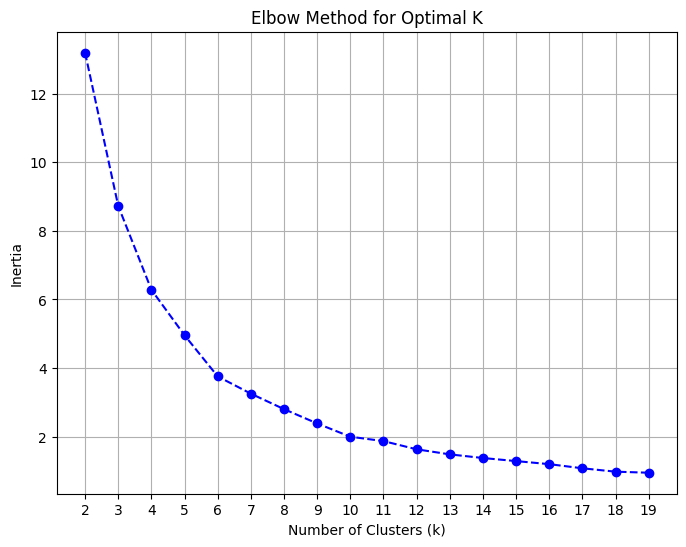

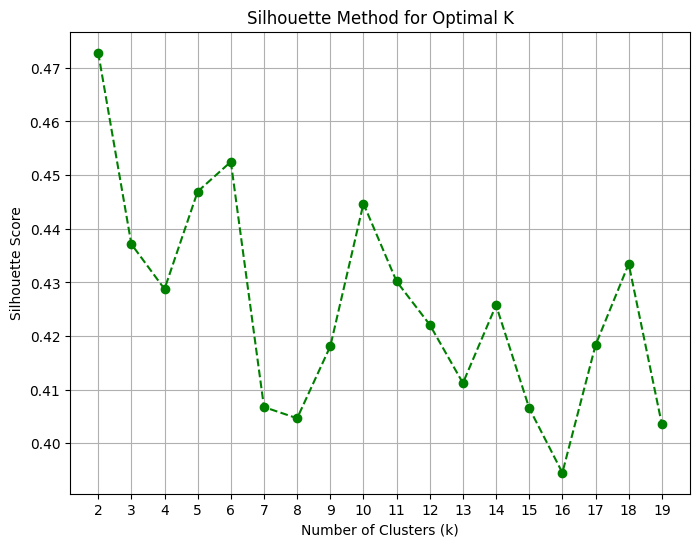

In [33]:
for features in feature_sets:
    print(f"\nΤρέχουμε αξιολόγηση για: {features}")
    X = scaled_df[features]
    evaluate_kmeans_range(X,range(2,20))

## Συμπέρασμα
Αρχικά, η μεταβλητή `Gender_code` δεν επιλέχθηκε για χρήση στο clustering, λόγω της πολύ ασθενούς συσχέτισής της με το `Spending Score (1-100)` (~0.06). Αν και εξετάστηκε πειραματικά, τελικά **αποκλείστηκε από όλους τους συνδυασμούς χαρακτηριστικών**, επειδή δεν προσέφερε βελτίωση στα αποτελέσματα και επηρέαζε αρνητικά το Silhouette Score.

Παρόλο που και η μεταβλητη `Annual Income` έχει μηδαμινή συνεισφορά (~0,01), δεν έδειξε να επηρεάζει αρνητικά τα αποτελέσματα οπότε συμπεριλήφθηκε

## Το καλύτερο Silhouette Score με αρκετά σταθερό k εντοπίστηκε:

    0.4307 για k = 9

    με χαρακτηριστικά 
            --Age 
            --Annual Income (k$)
            --Spending Score (1-100)

    Παρόμοιο σκορ εμφανίζεται και στο k = 6, αλλά το k = 9 έχει ελαφρώς καλύτερη ποιότητα clustering

### 🔬 Πειραματική αξιολόγηση μεθόδων Scaling

Δοκιμάστηκαν **όλες οι διαθέσιμες μέθοδοι** από τη συνάρτηση `scale_features()`:

- **StandardScaler**: Απαιτεί κανονική κατανομή. Δεν ενδείκνυται, καθώς οι μεταβλητές μας δεν είναι κανονικά κατανεμημένες.
- **MinMaxScaler**: Ιδανικός για δεδομένα με θετικές τιμές και ασύμμετρη κατανομή — **επέλεγη τελικά**.
- **MaxAbsScaler**: Κατάλληλος για δεδομένα με **αρνητικές και θετικές τιμές**, που **δεν έχουμε** στην περίπτωσή μας.
- **RobustScaler**: Κατάλληλος για περιπτώσεις με **outliers**. Όμως εδώ οι ακραίες τιμές έχουν **ήδη αφαιρεθεί** μέσω IQR.
- **Normalizer**: Δεν είναι κατάλληλος για την περίπτωση μας.

Στην περίπτωση **χωρίς scaling**, τα αποτελέσματα ήταν σε ορισμένες περιπτώσεις ικανοποιητικά (ιδιαίτερα χωρίς το `Gender_code`), αλλά δημιουργούνταν **ανισορροπία μεταξύ μεταβλητών**:
- Π.χ. το `Annual Income (k$)` έχει τιμές έως 139
- Ενώ το `Age` φτάνει μόνο έως 70
- Παρότι το `Age` έχει μεγαλύτερη συσχέτιση με το target, η συμβολή του στο clustering θεώρησα πως μειώνεται λόγω μικρότερης αριθμητικής κλίμακας. Για αυτό το λόγο δεν θα προχωρήσω χωρίς scaling παρόλο που στην περίπτωση χωρίς scaling θπήρχαν αρκετά ξεκάθαρα αποτελέσματα.
---
### Τελική Επιλογή: MinMaxScaler

Ο **MinMaxScaler** παρόλο που δεν έδινε τόσο ξεκάθαρα αποτελέσματα σε σχέση με τους υπόλοιπους scalers επελέγη επειδή:

- Όλες οι μεταβλητές έχουν **θετικές τιμές**
- Οι κατανομές είναι **ασύμμετρες και όχι κανονικές**
- Δεν υπάρχουν πλέον outliers (έγινε καθαρισμός με IQR)
- Είναι ο καταλληλότερος για εξισορρόπηση μεταβλητών σε κοινή κλίμακα [0, 1] χωρίς παραμόρφωση

---



## Βήμα 11: Παραμετροποίηση του KMeans (Tuning)

Σύμφωνα με την εκφώνηση της εργασίας, στο στάδιο αυτό γίνεται πειραματισμός με τις παραμέτρους του αλγορίθμου KMeans, με σκοπό τη βελτίωση της σταθερότητας και της ποιότητας του clustering.

Οι παράμετροι που αξιολογήθηκαν είναι οι εξής:

- `init`: Μέθοδος αρχικοποίησης των κέντρων (`'k-means++'` ή `'random'`)
- `n_init`: Πλήθος διαφορετικών εκκινήσεων με τυχαία centroids (π.χ. 10, 20, 50)
- `max_iter`: Μέγιστος αριθμός επαναλήψεων ανά εκτέλεση KMeans (π.χ. 300, 500, 1000)

---

### Σκοπός παραμετροποίησης

Η διαδικασία tuning έγινε για να:

- Ελεγχθεί η ευαισθησία του μοντέλου σε διαφορετικές αρχικοποιήσεις
- Ελαχιστοποιηθεί το `inertia_` (ενδοκλασική διασπορά)
- Διασφαλιστεί ότι ο αλγόριθμος συγκλίνει αξιόπιστα, ακόμα και σε περιπτώσεις με υψηλό `max_iter`

---

### Τεχνική Προσέγγιση

Για κάθε συνδυασμό παραμέτρων καταγράφηκε το **τελικό `inertia_`**, το οποίο είναι δείκτης της συνοχής των clusters. Μικρότερο `inertia` συνεπάγεται μεγαλύτερη πυκνότητα εντός των clusters.

Η αξιολόγηση έγινε με σταθερό `k = 9`, το οποίο είχε εντοπιστεί ως βέλτιστο στα προηγούμενα βήματα.

---

In [34]:
params = [
    ('k-means++', 10, 300),
    ('k-means++', 20, 300),
    ('k-means++', 50, 300),
    ('random', 10, 300),
    ('random', 50, 300),
    ('k-means++', 10, 500),
    ('random', 20, 1000),
]

for init_method, n_init, max_iter in params:
    print(f"\nInit: {init_method}, n_init: {n_init}, max_iter: {max_iter}")
    model = run_kmeans(
        scaled_df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]],
        n_clusters=9,
        init_method=init_method,
        n_init=n_init,
        max_iter=max_iter
    )


Init: k-means++, n_init: 10, max_iter: 300
Inertia:
 5.4619615213769475

Init: k-means++, n_init: 20, max_iter: 300
Inertia:
 5.4619615213769475

Init: k-means++, n_init: 50, max_iter: 300
Inertia:
 5.4619615213769475

Init: random, n_init: 10, max_iter: 300
Inertia:
 5.465571374543601

Init: random, n_init: 50, max_iter: 300
Inertia:
 5.465571374543601

Init: k-means++, n_init: 10, max_iter: 500
Inertia:
 5.4619615213769475

Init: random, n_init: 20, max_iter: 1000
Inertia:
 5.465571374543601


### Συμπεράσματα

- Η μέθοδος **`k-means++`** έδωσε **σταθερά και βέλτιστα αποτελέσματα**, με μικρότερο `inertia` σε όλες τις περιπτώσεις.
- Η αύξηση του `n_init` και του `max_iter` **δεν βελτίωσε περαιτέρω την απόδοση**, γεγονός που δείχνει ότι ο αλγόριθμος συγκλίνει αξιόπιστα με τις default τιμές.
- Η μέθοδος **`random`** έδωσε ελαφρώς **χειρότερα αποτελέσματα**, με μεγαλύτερο `inertia`, ανεξαρτήτως `n_init` ή `max_iter`.

Ως τελική διαμόρφωση του μοντέλου προτείνεται:

```python
run_kmeans(..., init_method="k-means++", n_init=10, max_iter=300)

## Βήμα 12: Οπτικοποίηση των Clusters

Η οπτικοποίηση των αποτελεσμάτων του KMeans clustering επιτρέπει την κατανόηση της κατανομής των ομάδων στο χαρακτηριστικό χώρο.

---

### Οδηγίες από την εργασία:

- **2D απεικόνιση**: Όταν χρησιμοποιούνται δύο χαρακτηριστικά
- **3D απεικόνιση**: Όταν περιλαμβάνεται τρίτο χαρακτηριστικό
- **4 ή περισσότερα χαρακτηριστικά**: Επιλέγονται τα πιο σημαντικά (π.χ. μέσω συσχέτισης) για απεικόνιση σε 2D ή 3D

---

### Εφαρμογή σε αυτή την εργασία:

Ο τελικός συνδυασμός χαρακτηριστικών που χρησιμοποιήθηκε για clustering ήταν:

- `Age`
- `Annual Income (k$)`
- `Spending Score (1-100)`

Προχωράμε στην απεικόνιση των αποτελεσμάτων σε:

- **2D**: με χρήση `Age` και `Spending Score`
- **2D**: με χρήση `Annual Income` και `Spending Score`
- **3D**: με χρήση και των τριών χαρακτηριστικών

Inertia:
 5.4619615213769475


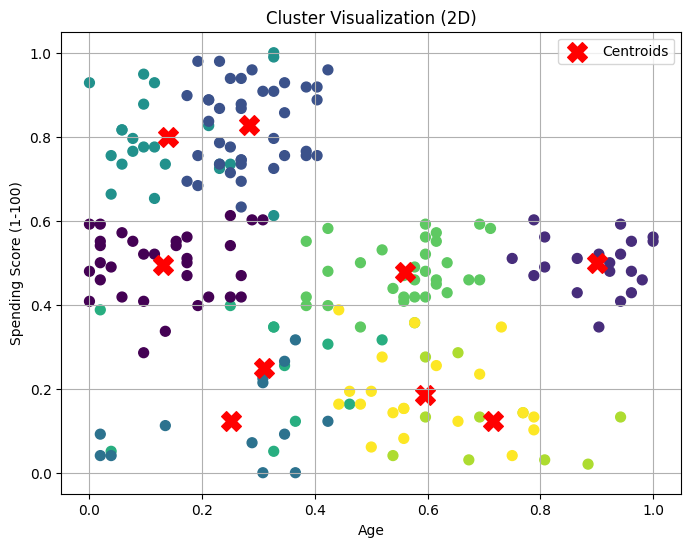

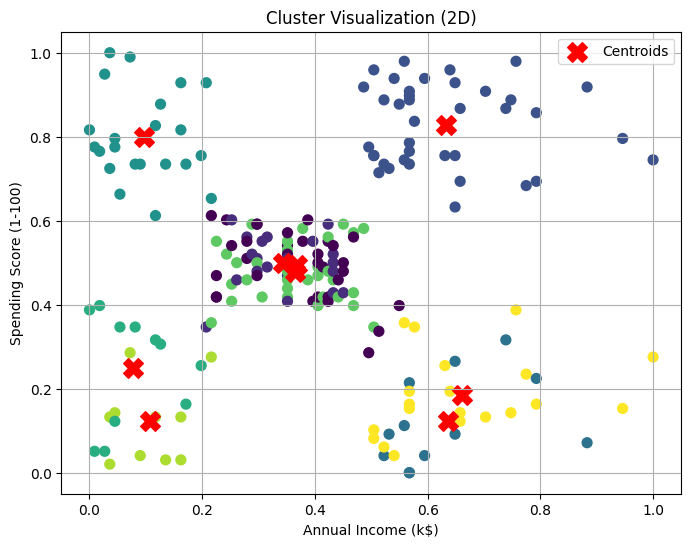

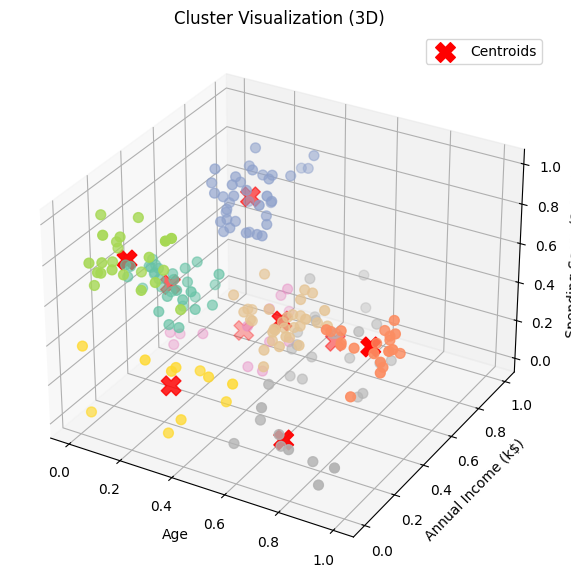

In [35]:
# Τελική εκτέλεση clustering
final_model = run_kmeans(
    scaled_df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]],
    n_clusters=9,
)

# 2D Visualization
visualize_clusters(
    model=final_model,
    df=scaled_df,
    features=["Age", "Spending Score (1-100)"],
    mode="2D"
)

# 2D Visualization
visualize_clusters(
    model=final_model,
    df=scaled_df,
    features=["Annual Income (k$)", "Spending Score (1-100)"],
    mode="2D"
)

# 3D Visualization
visualize_clusters(
    model=final_model,
    df=scaled_df,
    features=["Age", "Annual Income (k$)", "Spending Score (1-100)"],
    mode="3D"
)

## Ανάλυση Cluster με Υψηλό Spending Score

Χρησιμοποιούμε τη συνάρτηση `analyze_top_cluster()` για να εντοπίσουμε **όλα τα clusters** που εμφανίζουν **υψηλή μέση τιμή** στη μεταβλητή `Spending Score (1-100)` και να αναλύσουμε τα χαρακτηριστικά των πελατών τους.

Η παράμετρος `threshold=75` ορίζει το κατώφλι της μέσης τιμής, δηλαδή εντοπίζονται όλα τα clusters με `Spending Score >= 75`.

Η παράμετρος `exclude="Gender_code"` χρησιμοποιείται ώστε η μεταβλητή `Gender_code` να **μην συμπεριληφθεί** στην περιγραφή του cluster, καθώς δεν θεωρείται χρήσιμη για τη συγκεκριμένη ανάλυση.

Η συνάρτηση **δεν επιστρέφει τιμή**, αλλά **εκτυπώνει περιγραφικά στατιστικά** (`describe()`) για κάθε cluster που πληροί το κριτήριο, επιτρέποντάς μας να εντοπίσουμε τα δυναμικά κοινά-στόχους με βάση τη συμπεριφορά κατανάλωσης.

In [36]:
analyze_cluster = analyze_top_cluster(final_model, df_corr_input, threshold = 75,exclude="Gender_code")

Clusters με μέση τιμή Spending Score (1-100) >= 75:

              mean
Cluster           
2        82.105263
4        79.363636

Περιγραφικά στατιστικά για Cluster 2:

             Age  Annual Income (k$)  Spending Score (1-100)  Cluster
count  38.000000           38.000000               38.000000     38.0
mean   32.763158           85.210526               82.105263      2.0
std     3.752003           14.235771                9.489082      0.0
min    27.000000           69.000000               63.000000      2.0
25%    30.000000           75.250000               74.250000      2.0
50%    32.000000           78.500000               84.000000      2.0
75%    35.750000           91.750000               90.000000      2.0
max    40.000000          126.000000               97.000000      2.0

Περιγραφικά στατιστικά για Cluster 4:

             Age  Annual Income (k$)  Spending Score (1-100)  Cluster
count  22.000000           22.000000               22.000000     22.0
mean   25.272727     

## Βήμα 14:Ανάλυση Κορυφαίου Cluster

Με βάση τη σύνοψη του `Spending Score (1-100)` για όλα τα clusters, εντοπίζονται δύο ομάδες πελατών με εξαιρετικά υψηλή μέση κατανάλωση:
 Cluster  Μέση Τιμή Spending Score 
 2        82.11                    
 4        79.36                    

###  Cluster 2 — Νέοι προς μέση ηλικία με υψηλό εισόδημα

- **Μέση ηλικία**: ~33 ετών
 
- **Μέσο ετήσιο εισόδημα**: ~$85.000
  
- **Μέσο spending score**: ~82
 
- **Εύρος ηλικίας**: 27-40
 
- **Εύρος εισοδήματος**: 69-126 k$

### Insights:

- Οι πελάτες του Cluster 2 είναι **σχετικά νέοι** (27–40 ετών)
- Έχουν **υψηλό εισόδημα** (85k μέσος όρος)
- Και **πολύ υψηλό ενδιαφέρον / κατανάλωση** (Spending Score έως και 97)

###  Cluster 4 — Νέοι με χαμηλότερο εισόδημα

- **Μέση ηλικία**: ~25 ετών
 
- **Μέσο ετήσιο εισόδημα**: ~$25.700
 
- **Μέσο spending score**: ~79
 
- **Εύρος ηλικίας**: 18–35
 
- **Εύρος εισοδήματος**: 15–39 k$

### Insights:

- Οι πελάτες του Cluster 4 είναι **πολύ νεότεροι** (18–35 ετών)
- Έχουν **χαμηλότερο εισόδημα** (μέσος όρος ~$25k)
- Αλλά δείχνουν **πολύ υψηλό ενδιαφέρον / κατανάλωση** (Spending Score έως και 99)


Ανεξαρτήτως εισοδήματος, οι πελάτες με **ηλικία κάτω του μέσου όρου** τείνουν να παρουσιάζουν **υψηλότερη αγοραστική δραστηριότητα**. Η ηλικία αναδεικνύεται ως **ισχυρότερος παράγοντας πρόβλεψης της κατανάλωσης** από το εισόδημα.
